# Estimating COVID-19's $R_t$ in Real-Time (Nigeria)
Chidindu Promise Ogbonna - May 1


I came across an analysis by [Kevin Systrom](https://twitter.com/kevin) on this exact topic, [Estimating COVID-19's $R_t$ in Real-Time](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb). But that was done on the coronavirus pandemic in the United States. 
This analysis is an attempt at estimating the COVID-19s $R_t$ in Real-Time in **Nigeria**.

$R_t$ is a measure of the **Effective Reproduction Number**, it's the number of people who become infected for every infectious person at time $t$, the virus' actual rate transmission rate a given moment. The detection and tracking of an emerging disease can be formalized in terms of monitoring $R_t$, as it evolves and approaches the critical threshold $R_t > 1$. In an article referenced by Kevin, [on gradually lifting the lockdown](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html), it established this metric ($R_t$) as a "formal framework for how governments could monitor the state of this pandemic...", performing much better than daily/weekly count of reported cases. Calculating $R_t$ works because it tries to make up for poor reporting of cases, [where cases reported do not show the actual severity of the virus](https://medium.com/@6ones/how-is-nigeria-faring-in-the-fight-against-covid-19-f52bfc81b8a), where there are not enough test-kits to enable proper testing of the population or where cases are only reported when symptoms show.

> Policy must not be determined based on the daily count of reported cases — the tallies you read about constantly in the news — because those are unreliable. What’s needed instead is the coronavirus’s real-time, effective reproduction number, or its actual ability to spread at a particular time.

An $R_t >= 1$ means the epidemic is eating deep into the society, for every infected person, another person becomes infected. At $R_t < 1$, the epidemic will **fade out**, and at $R_t = 0$, this indicates complete absence of human to human transmission, which is what we want. No matter how badly the economy is doing, the epidemic fading out should be the number one priority of any government.

Kevin noted how understanding the $R_t$ at a national level is not useful, but rather should be done at a local level (State) to get a granular version of $R_t$.  
Using a modified version (a process model with Gaussian noise to estimate a time varying $R_t$) of the solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185), which uses a Bayesian approach to estimate $R_t$ in real-time. I won't go into detail in explaining the the methods used to evaluate $R_t$, but you can check Kevin's [version](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb), where he explains all this.

If you want to contact me, probably tell me what I did wrong, feel free to hit me up at [chidindu@datahorror.com](mailto:chidindu@datahorror.com)

In [407]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

from scipy import stats
from scipy.interpolate import interp1d

from IPython.display import clear_output
%matplotlib inline

## Setup

### Download data
Using this [dataset](https://github.com/6ones/covid-19-data.ng) which curates covid-19 cases at a state level.

In [73]:
!git clone https://github.com/6ones/covid-19-data.ng ./data
clear_output()

### Load Data

In [74]:
confirmed_cases = pd.read_csv('./data/confirmed.csv', parse_dates=['date'], index_col='date')

In [134]:
all_states = list(confirmed_cases.columns.unique())

In [136]:
total_cases = confirmed_cases.diff().sum(axis=0).rename('total cases').reset_index().rename(columns={'index': 'states'})

cases_greater_than_40 = list(total_cases.loc[total_cases['total cases'] > 40].states.unique())
print('States with more than 40 cases: ', cases_greater_than_40)

States with more than 40 cases:  ['Bauchi', 'Borno', 'Edo', 'FCT', 'Gombe', 'Kano', 'Lagos', 'Ogun', 'Sokoto']


In [80]:
def get_cases_for_state(state_name):
    return confirmed_cases.loc[:, state_name]
kano = get_cases_for_state('Kano')
kano.to_frame().tail()

,Kano
date,
2020-04-27,77
2020-04-28,115
2020-04-29,139
2020-04-30,219
2020-05-01,311


&nbsp;

## Gaussian Filtering
Applying gaussian filtering to the timeseries, we can see how this makes up for poor reporting and discovery of new cases. Comparing the "actual" cases vs the "smoothed" cases, we have the smoothed showing a more realistic view of the growth of new cases.

In [35]:


def prepare_cases(cases, cutoff=5):
    """Prepare data for analysis, starting from a when there are a consistent number of cases.
    Apply gaussian filtering to the timeseries, to get the best view of the "true" data
    
    Params:
        cases: DataFrame, Timeseries of cases
        cutoff: int, number of cases to start from
    Returns:
        (original, smoothed): tuple, return original cases and smoothed (using a rolling window using gaussian method).
    """
    new_cases = cases.diff()
    smoothed = new_cases.rolling(7, 
                                 win_type='gaussian', 
                                 min_periods=1, 
                                 center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)[0]
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

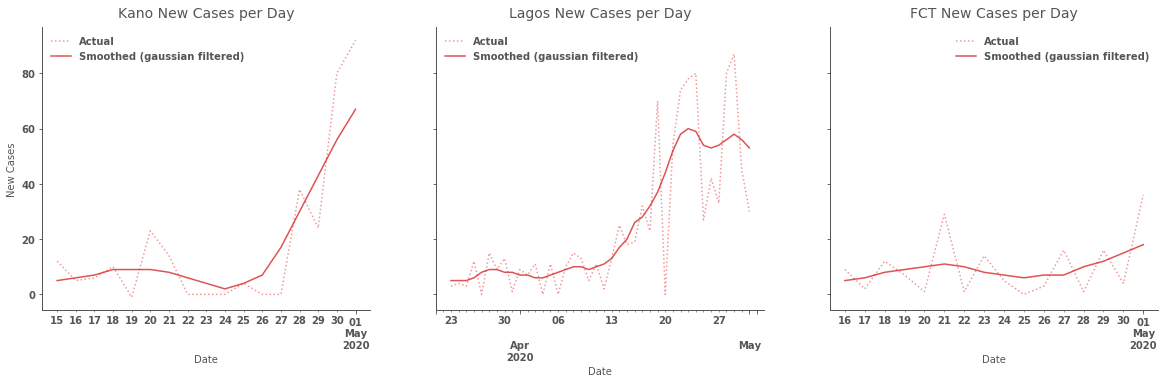

In [79]:
fig, axes = plt.subplots(1,3, figsize=(20,5), sharey=True)
axes = axes.ravel()

states = ['Kano', 'Lagos', 'FCT']
for state, ax in zip(states, axes):
    cases = get_cases_for_state(state)
    original, smoothed = prepare_cases(cases)
    original.plot(title=f'{state} New Cases per Day', linestyle=':', alpha=.5, label='Actual', legend=True, ax=ax)
    smoothed.plot(label='Smoothed (gaussian filtered)', legend=True, alpha=.8, ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('New Cases')


&nbsp;
## Estimating $R_t$

### Bettencourt & Ribeiro's Approach
By the daily reporting of new infectious of the COVID-19, this gives a clue of the current value of $R_t$. We also, figure that the value of $R_t$ tody is related to the value of $R_{t-1}$ (yesterday's value).

The author's used Bayes' theorem to estimate/predict the true value of $R_t$, (predict, because we really do not know the true cases, but can only estimate based on what is reported daily).

Bayes Theroem :  $$ P(R_t|k) = \frac{P(k|R_t)\cdot P(R_t)}{P(k)}$$

This says for every new cases reported $k$, we believe the distribution of $R_t$ is equal to:
  * The **likelihood** of seeing new cases, $k$, given $R_t$ multiplied with ...
  * The **prior** beliefs of the values of $P(R_t)$ without the data
  * divided by the probablity of seeing $k$ cases
  
&nbsp;
### Calculating posteriors

Posteriors refers to the next possible value of $R_t$, where the prior is $R_{t-1}$.  
Steps for calculating posteriors.

1. Calculate $\lambda$ - the expected arrival rate for every day's poisson process.
2. Calculate each day's likelihood distribution over all possible values of $R_t$
3. Calculate the process matrix based on the value of $\sigma$
4. Calculate our initial prior because our first day does not have a previous days from which to take posterior
  * Based on [information by the cdc](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article), which suggested a doubling time of the number of infected persons of 6-7 days, 7 will be chosen as the Gamma.
5. Loop from day 1 to the end, while:
  * Calculating the prior by applying the Gaussian to yesterday's prior
  * Apply Bayes' rule by multiplying this prior and the likelihood calculated in step 2.
  * Divide by the probability of the data (also Bayes' rule)

In [41]:
GAMMA = 7 # Serial interval based on information from the cdc
R_T_MAX = 12  # Array for every possible value of Rt
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

def get_posteriors(sr, sigma=0.15):
    
    # 1. Calculate lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    
    # 2. Calculate each day's likelihood.
    likelihoods = pd.DataFrame(data=stats.poisson.pmf(sr[1:].values, lam),
                              index=r_t_range,
                              columns=sr.index[1:])
    
    # 3. Create the Gaussian matrix
    process_matrix = stats.norm(loc=r_t_range,
                               scale=sigma).pdf(r_t_range[:,None])
    
    #  Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # 4. Calculate the initial prior
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()
    
    posteriors = pd.DataFrame(index=r_t_range,
                             columns=sr.index,
                             data={sr.index[0]:prior0})
    
    log_likelihood = 0.0
    
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):
        
        current_prior = process_matrix @ posteriors[previous_day]
        
        numerator = likelihoods[current_day] * current_prior
        
        denominator = np.sum(numerator)
        
        posteriors[current_day] = numerator/denominator
        
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

In [169]:
lagos_cases = get_cases_for_state('Lagos')
original, smoothed = prepare_cases(lagos_cases)
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.1)

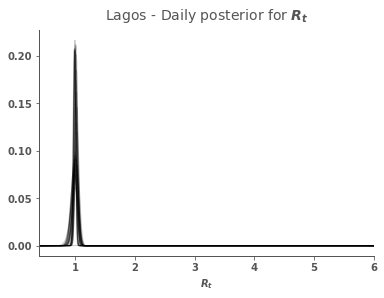

In [170]:
ax = posteriors.plot(title='Lagos - Daily posterior for $R_t$', 
                legend=False, 
                lw=1, 
                c='k', 
                alpha=.2, 
                xlim=(0.4,6));
ax.set_xlabel('$R_t$');

### Plotting Across Time With Intervals Making Use of The Highest Density Intervals
The **Highest Density Interval** indicates which points of a distribution are most credible, and which cover most of the distribution.

Since this is a predicted or estimated value, intervals give room for errors

In [171]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

In [172]:
most_likely_values = posteriors.idxmax(axis=0).rename('Most likely')
hdi = highest_density_interval(posteriors, debug=True)

most_likely_values = most_likely_values[1:]
hdi = hdi.loc[most_likely_values.index]

result = pd.concat([most_likely_values, hdi], axis=1)
result.head()

,Most likely,Low_90,High_90
date,,,
2020-03-24,1.00,0.87,1.09
2020-03-25,1.00,0.89,1.08
2020-03-26,1.02,0.91,1.09
2020-03-27,1.04,0.94,1.10
2020-03-28,1.02,0.93,1.08


### Calculate $R_t$

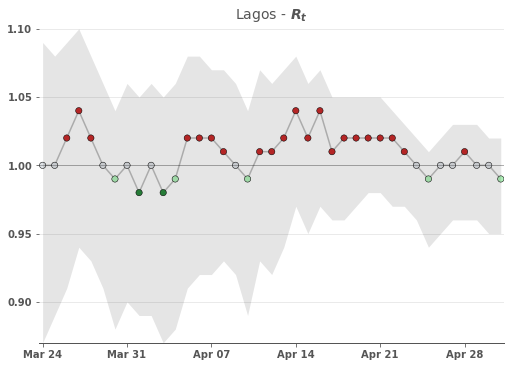

In [176]:
# colors: D - dark, L - light
L_GREEN = '#2b8a3e'
D_GREEN = '#b2f2bb'
GREY = '#dee2e6'
L_RED = '#f03e3e'
D_RED = '#c92a2a'


def plot_rt(result, ax, state_name):
    
    
    index = result['Most likely'].index
    values = result['Most likely'].values
    
    cmap = ListedColormap([L_GREEN, D_GREEN, GREY, L_RED, D_RED])
    norm = BoundaryNorm([np.min(values), 0.99, 1.00, 1.01, np.max(values)], cmap.N)

    ax.plot(index, values, c='k', zorder=1, alpha=.25,  markersize=10)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=values,
               norm=norm,
               cmap=cmap,
               edgecolors='k',
               zorder=2)              
    
    lowfn = interp1d(date2num(index), 
                     result['Low_90'].values,
                    bounds_error=False,
                    fill_value='extrapolate')
    highfn = interp1d(date2num(index), 
                     result['High_90'].values,
                    bounds_error=False,
                    fill_value='extrapolate')
    
    ax.fill_between(index, 
                    lowfn(date2num(index)),
                    highfn(date2num(index)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)
    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25)
    
    ax.set_title(f'{state_name} - $R_t$')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    
    ax.yaxis.tick_left()
    ax.spines['left'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(result['Low_90'].min(),result['High_90'].max());
    fig.set_facecolor('w')
    
fig, ax = plt.subplots(figsize=(600/72,400/72))
plot_rt(result, ax, 'Lagos')

&nbsp;
### Choosing optimal $\sigma$

The $\sigma$ (standard deviation) determines the spread of the $R_t$, the higher it is the farther it is from the previous day. 

Detailed processes on how the $\sigma$ for this process can be seen [here](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb).

In [124]:
sigmas = np.linspace(1/20, 1, 20)

results = {}

for state in cases_greater_than_40:
    cases = get_cases_for_state(state)
    
    original, smoothed = prepare_cases(cases)
    
    if len(smoothed) == 0:
        print(f'{state} is excluded in deriving sigma')
        continue

    result = {}
    
    result['posteriors'] = []
    result['log_likelihoods'] = []
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    results[state] = result
    
print('Done')

Ogun is excluded in deriving sigma
Done


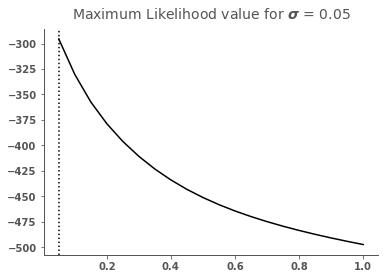

In [115]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods, c='k')
ax.axvline(sigma, color='k', linestyle=":");

&nbsp;
### Using the derived $\sigma$, calculate $R_t$ for states above 40 cases

Calculate $R_t$ for states that have enough data, where there are no enough cases reported, it would be useless to perform gaussian filtering, and also calculating highest density intervals would be impossible

In [146]:
final_results = {}

for state in all_states:
    cases = get_cases_for_state(state)
    original, smoothed = prepare_cases(cases, cutoff=5)
    
    if (len(smoothed) == 0):
        print(f'{state} not included: not enough cases to calculate Rt')
        continue
    
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=0.05)
    hdi_90 = highest_density_interval(posteriors, p=.9)
    hdi_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('Most likely')
    result = pd.concat([most_likely, hdi_90, hdi_50], axis=1)
    final_results[state] = result
    
    clear_output(wait=True)
print('Done!')

Taraba not included: not enough cases to calculate Rt
Yobe not included: not enough cases to calculate Rt
Zamfara not included: not enough cases to calculate Rt
Done!


In [154]:
states_with_enough_data = list(final_results.keys())

&nbsp;
## Plot all Nigerian states with sufficient data reported

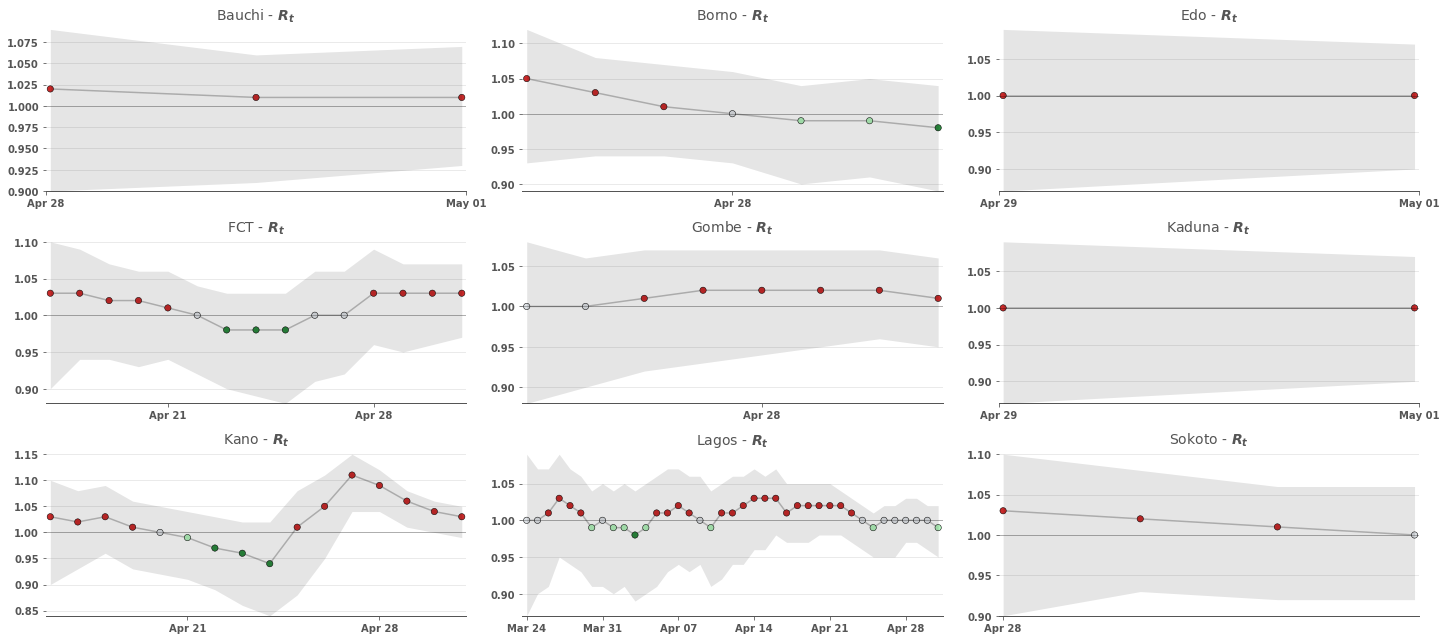

In [425]:
ncols = 3
nrows = int(np.ceil(len(final_results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*3))
axes = axes.ravel()
fig.subplots_adjust(hspace=4)

for i, (state, result) in enumerate(final_results.items()):
    plot_rt(result.iloc[1:], axes[i], state)

fig.tight_layout()
fig.set_facecolor('w')
plt.savefig('images/all_states_rt')

#### We see that among all the states plotted above, only Lagos and Borno have $R_t < 1$

In [359]:
latest_rt = {result: final_results[result].iloc[-1] for result in final_results}
latest_rt = pd.DataFrame(latest_rt).T
latest_rt = latest_rt.sort_values(by=['Most likely'])

ml = latest_rt['Most likely']
err = latest_rt[['Low_90', 'High_90']].sub(latest_rt['Most likely'], axis=0).abs()

&nbsp;

#### Showing most recent $R_t$ by state among some of the worst hit states

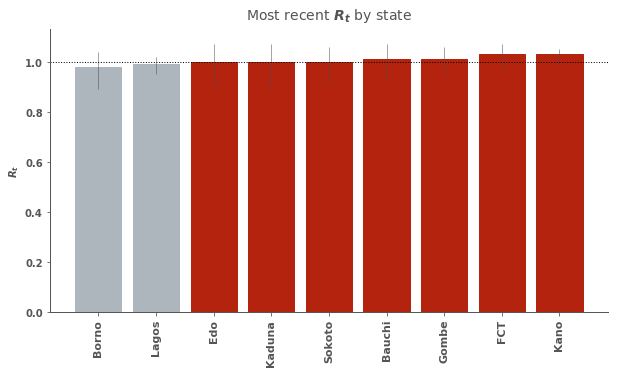

In [421]:
fig, ax = plt.subplots(figsize = (10,5))

bars = ax.bar(ml.index, 
              ml,
              ecolor=ERROR_BAR_COLOR,
              error_kw={'alpha':.5, 'lw':1, 'linestyle':':'},
              yerr=err.values.T)
for bar, rt in zip(bars, ml):
    if rt < 1:
        bar.set_color('#adb5bd')
    else:
        bar.set_color([179/255,35/255,14/255])


ax.axhline(1.0, linestyle=':', color='k', lw=1)
ax.set_ylim(0, np.max(ml.values+0.1))
ax.set_title('Most recent $R_t$ by state')
ax.set_ylabel('$R_t$')
ax.margins(0.05)
ax.set_xticklabels(labels=ml.index,rotation=90, fontsize=11);
plt.savefig('images/most-recent-rt')

&nbsp;

### Plots Showing New Cases & $R_t$ per State

In [ ]:
new_cases = axes = axes.ravel()

states = ['Kano', 'Lagos', 'FCT']
for state, ax in zip(states, axes):
    cases = get_cases_for_state(state)
    original, smoothed = prepare_cases(cases)
    original.plot(title=f'{state} New Cases per Day', linestyle=':', alpha=.5, label='Actual', legend=True, ax=ax)
    smoothed.plot(label='Smoothed (gaussian filtered)', legend=True, alpha=.8, ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('New Cases')

In [442]:
cases_per_state = {}

for state in states_with_enough_data:
    cases = get_cases_for_state(state)
    original, smoothed = prepare_cases(cases)
    cases_per_state[state] = {}
    cases_per_state[state]['original'] = original
    cases_per_state[state]['smoothed'] = smoothed    

In [422]:
def plot_cases(result, ax, state):
    original = result['original']
    smoothed = result['smoothed']
    
    original.plot(title=f'{state} New Cases per Day', linestyle=':', alpha=.5, label='Actual cases', legend=True, ax=ax)
    smoothed.plot(label='Smoothed cases (Gaussian Filter)', legend=True, ax=ax)
    ax.set_ylabel('New Cases')
    ax.set_xlabel('Date')

&nbsp;
#### Kano

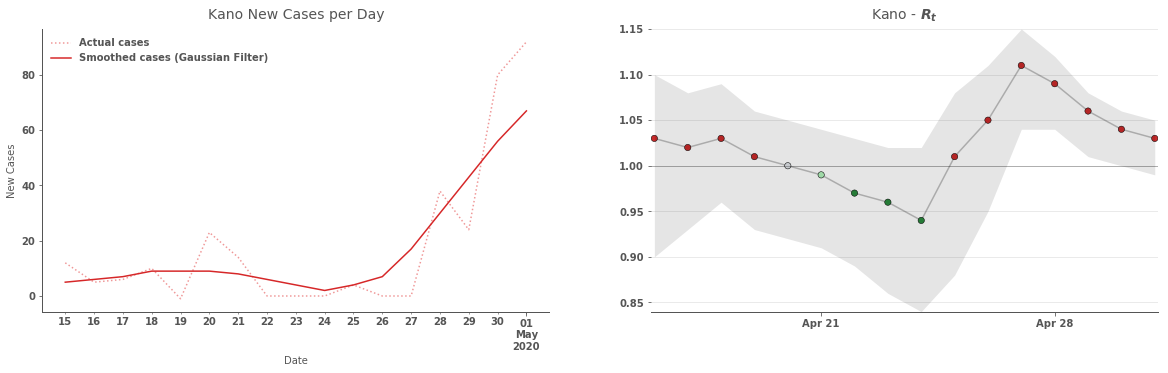

In [443]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_cases(cases_per_state['Kano'], axes[0], 'Kano')
plot_rt(final_results['Kano'].iloc[1:], axes[1], 'Kano')
plt.savefig('images/kano')

&nbsp;
#### FCT

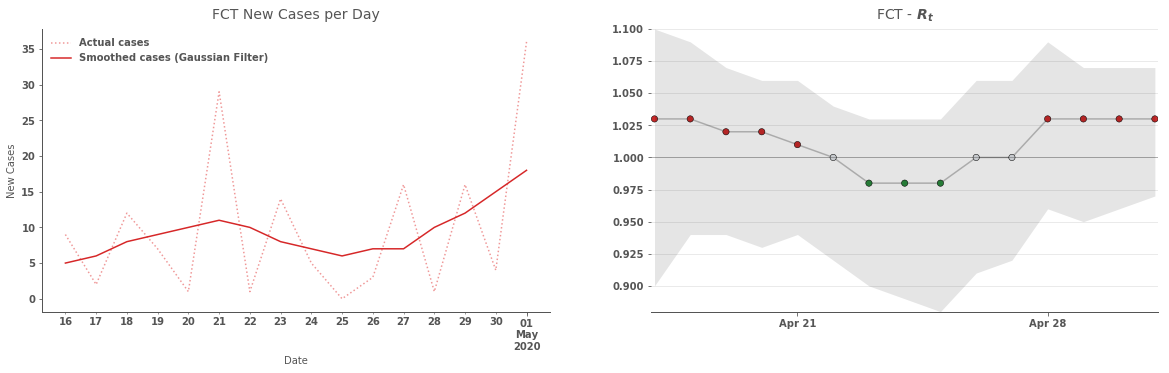

In [444]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_cases(cases_per_state['FCT'], axes[0], 'FCT')
plot_rt(final_results['FCT'].iloc[1:], axes[1], 'FCT')
plt.savefig('images/FCT')

&nbsp;
#### Lagos

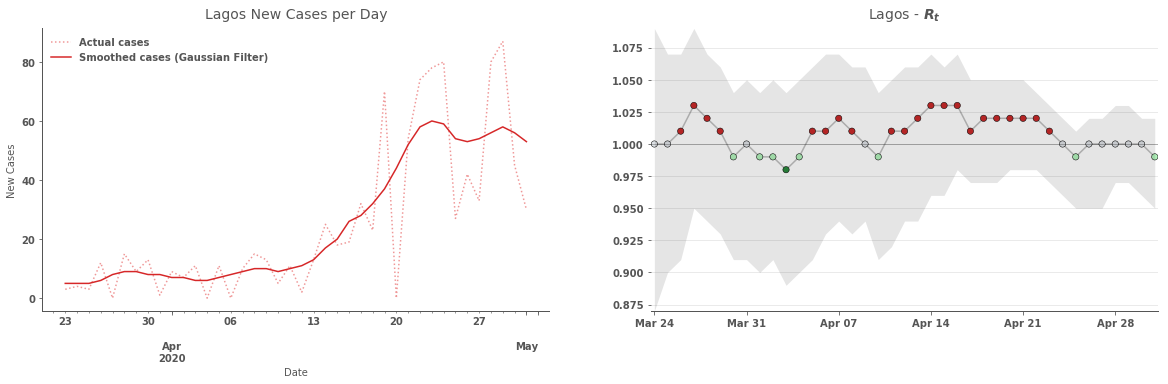

In [445]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_cases(cases_per_state['Lagos'], axes[0], 'Lagos')
plot_rt(final_results['Lagos'].iloc[1:], axes[1], 'Lagos')
plt.savefig('images/Lagos')

&nbsp;
#### Bauchi

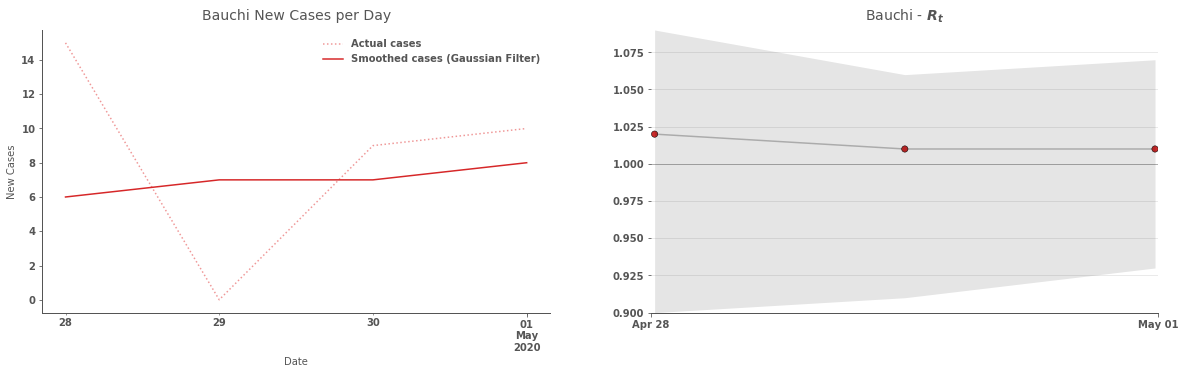

In [446]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_cases(cases_per_state['Bauchi'], axes[0], 'Bauchi')
plot_rt(final_results['Bauchi'].iloc[1:], axes[1], 'Bauchi')
plt.savefig('images/Bauchi')

&nbsp;
#### Gombe

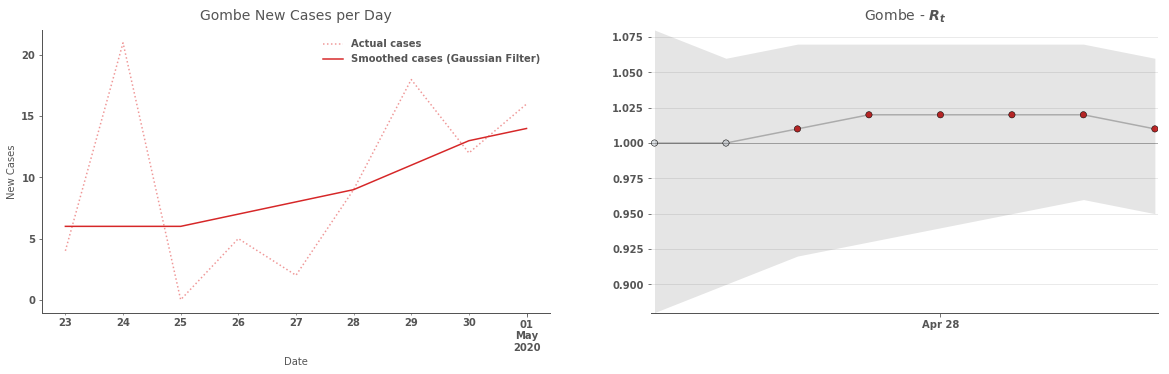

In [447]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_cases(cases_per_state['Gombe'], axes[0], 'Gombe')
plot_rt(final_results['Gombe'].iloc[1:], axes[1], 'Gombe')
plt.savefig('images/Gombe')

&nbsp;
#### Edo

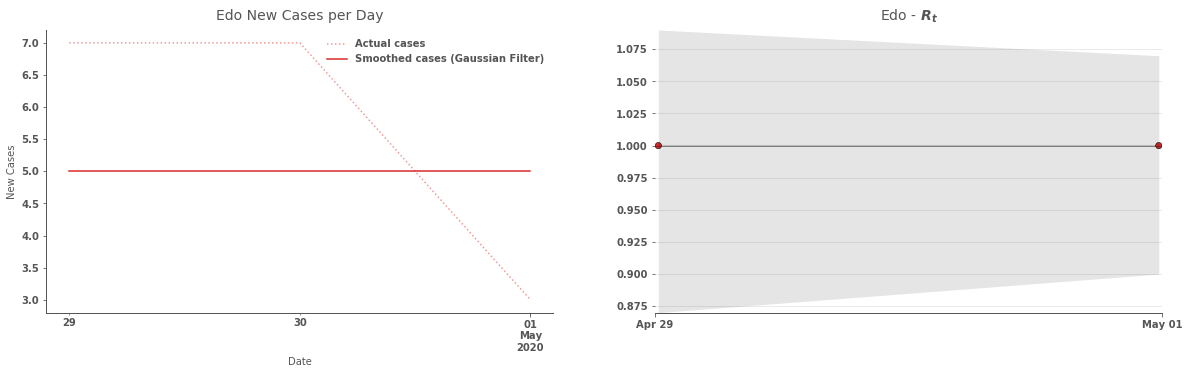

In [448]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_cases(cases_per_state['Edo'], axes[0], 'Edo')
plot_rt(final_results['Edo'].iloc[1:], axes[1], 'Edo')
plt.savefig('images/Edo')

&nbsp;
#### Sokoto

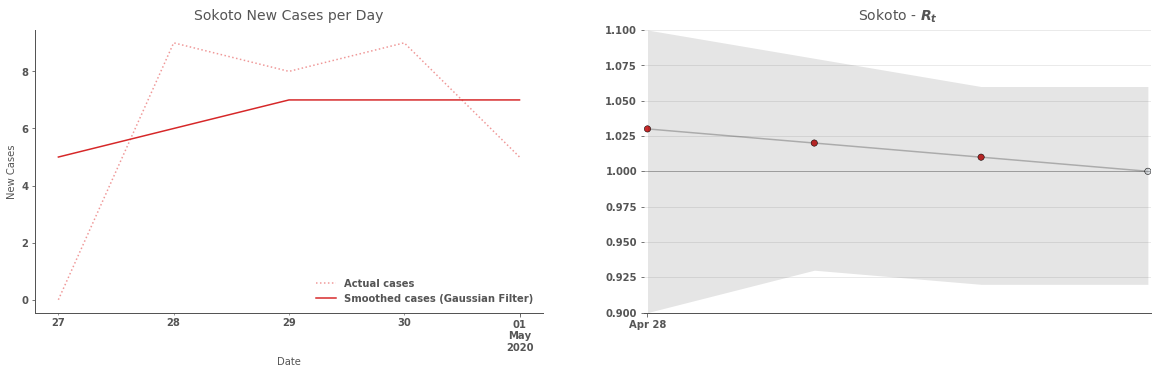

In [449]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_cases(cases_per_state['Sokoto'], axes[0], 'Sokoto')
plot_rt(final_results['Sokoto'].iloc[1:], axes[1], 'Sokoto')
plt.savefig('images/Sokoto')

&nbsp;
#### Kaduna

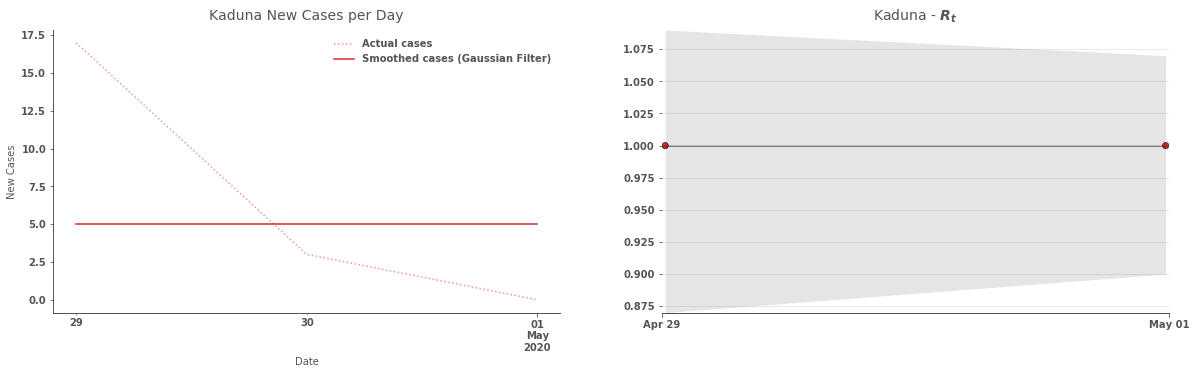

In [450]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_cases(cases_per_state['Kaduna'], axes[0], 'Kaduna')
plot_rt(final_results['Kaduna'].iloc[1:], axes[1], 'Kaduna')
plt.savefig('images/Kaduna')

&nbsp;
#### Borno

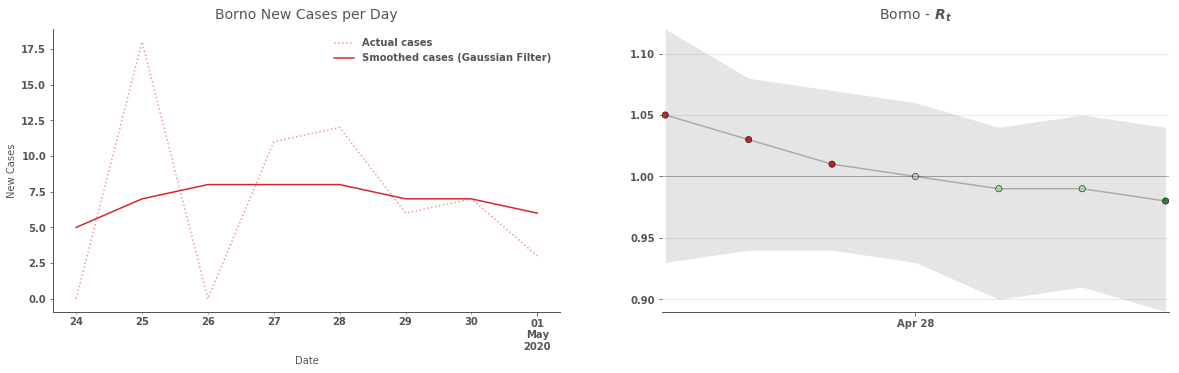

In [451]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_cases(cases_per_state['Borno'], axes[0], 'Borno')
plot_rt(final_results['Borno'].iloc[1:], axes[1], 'Borno')
plt.savefig('images/Borno')